Just download all datasets, and rename the folder of source 3 from `CheXpert-v1.0-small` to `CheXpert-v1.0` if you download small dataset

Template is taken from course's github [repo](https://github.com/iitkliv/ai61002_Spr2020/blob/master/Tutorial4_Training_LeNet_using_GD.ipynb), and some code is taken from my own submission in a [kaggle competition](https://www.kaggle.com/c/digit-recognizer)

Code is also taken heavily from Transfer learning tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Questions
Q: how you have split the dataset into train, test, validation?  
A: Yes, test was already given, so splitted into train and validation


Q: Chave you taken any methods to compensate for class imbalance?  
A: Yes, oversampling

Q: any conditions of hot restart during training?  
A: yes

Q: present the training/validation loss curves and indicate how you have chosen the stopping criteria?  
A: when validation loss starts increasing, that's the stopping criteria

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import math

import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.utils import resample
from skimage import io, transform


import time
import copy

In [3]:
# dataset folder contains all datasets
PATH = "data/dataset/"

In [4]:
!ls {PATH}

CheXpert-v1.0			  Figure1-COVID-chestxray-dataset-master
Covid19action-radiology-CXR_v1.1  rsna-pneumonia-detection-challenge
covid-chestxray-dataset-master


In [5]:
!ls data/dataset

CheXpert-v1.0			  Figure1-COVID-chestxray-dataset-master
Covid19action-radiology-CXR_v1.1  rsna-pneumonia-detection-challenge
covid-chestxray-dataset-master


In [6]:
!ls data/dataset/Covid19action-radiology-CXR_v1.1

images			      Test_Combined.csv       Train_Combined.csv
Readme_CXR_Database_v1.1.pdf  Test_Source3_task2.csv  Train_Source3_task2.csv


In [7]:
df = pd.read_csv("data/dataset/Covid19action-radiology-CXR_v1.1/Train_Combined.csv")

In [8]:
df

,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
0,CASE58_XRAY_1.jpeg,Source-2,1,0,0,1
1,case2_xray_1.jpeg,Source-2,1,0,0,1
2,case2_xray_2.jpeg,Source-2,1,0,0,1
3,case8_xray_1.jpeg,Source-2,1,0,0,1
4,case8_xray_2.jpeg,Source-2,1,0,0,1
...,...,...,...,...,...,...
228933,aspiration-pneumonia-5-day27.jpg,Source-5,4,0,1,0
228934,pneumocystis-jirovecii-pneumonia-3-1.jpg,Source-5,4,0,1,0
228935,pneumocystis-jirovecii-pneumonia-3-2.jpg,Source-5,4,0,1,0
228936,pneumocystis-jirovecii-pneumonia-3-3.jpg,Source-5,4,0,1,0


In [9]:
df["Data Source"].value_counts()

Source-3    223414
Source-4      5232
Source-5       128
Source-1       109
Source-2        54
Source-7         1
Name: Data Source, dtype: int64

In [10]:
def mod(source, img_name, plot=False):
    path = None
    if source == 1:
        path = PATH + "Covid19action-radiology-CXR_v1.1/images/Source1/"
        
    elif source == 2:
        path = PATH + "Covid19action-radiology-CXR_v1.1/images/Source2/"
        
    elif source == 3:
        # have to modify image name for this case
        # splitting image name accordingly
        z = img_name.split("__")
        img_name = z[-1]
        z[0] = z[0].split("/")[1] # Remove train_reshape
        z = z[:-1] # remove last 2 
        path = PATH + '/'.join([x for x in z]) + '/'
    elif source == 4:
        path = PATH + "rsna-pneumonia-detection-challenge/stage_2_test_images/"
    
    elif source == 5:
        path = PATH + "covid-chestxray-dataset-master/images/"
        
    elif source == 6:
        path = PATH + "Figure1-COVID-chestxray-dataset-master/images/"
    elif source == 7:
        path = PATH + "Covid19action-radiology-CXR_v1.1/images/Source7/"
    # for some images in testing file type is missing
    try:
        img = Image.open(path + img_name)
    except:
        try:
            img = Image.open(path+img_name + ".jpg")
        except:
            img = Image.open(path+img_name + ".png")
    if plot: 
        plt.imshow(img)
        plt.show()
    return img
        

#### Testing above function by plotting one image from each source

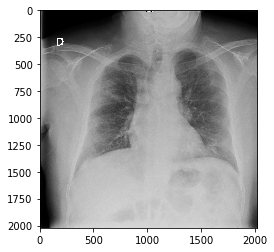

In [11]:
tmp = mod(1, "EUNQ4TDXkAAxvth.jfif", plot=True)

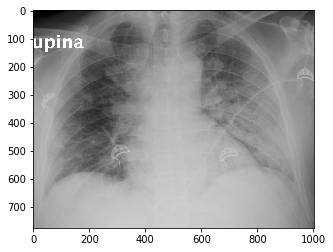

In [12]:
tmp = mod(2, "CASE58_XRAY_1.jpeg", plot=True)

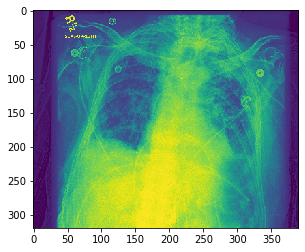

In [13]:
tmp = mod(3, "Train_reshape/CheXpert-v1.0__train__patient39740__study3__view1_frontal.jpg", plot=True)

In [14]:
tmp = mod(4, "IM-0217-0001.jpeg", plot=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data/dataset/rsna-pneumonia-detection-challenge/stage_2_test_images/IM-0217-0001.jpeg.png'

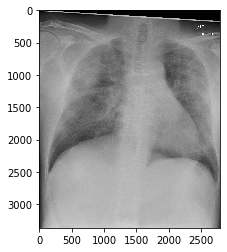

In [15]:
tmp = mod(5, "covid-19-pneumonia-15-PA.jpg", plot=True)

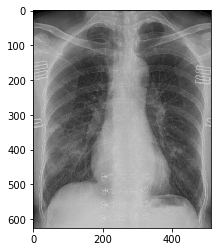

In [16]:
tmp = mod(7, "38_A.jpg", plot=True)

In [17]:
df["Other Pneumonia"] += 1
df["Non-Pneumonia"] += 1
# df = df[df["Data Source"] != "Source-4"]
# currently source 4 doesn't work
df = df[df["Data Source"] != "Source-4"]

## EDA

In [18]:
def plot_freq_chart(freq):
    sns.barplot(freq.index, freq.values)
    plt.title('Class frequency')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('city', fontsize=1)
    plt.show()


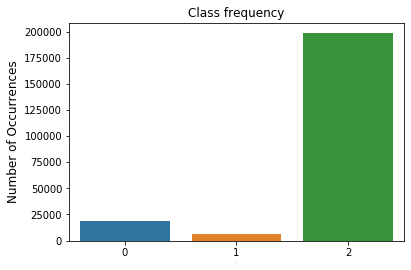

In [19]:
tmp = df["Non-Pneumonia"].value_counts()
plot_freq_chart(tmp)

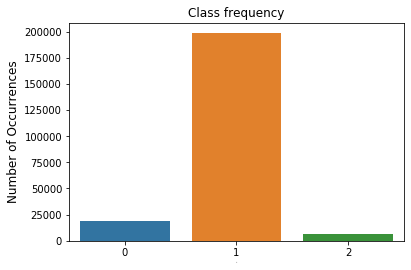

In [20]:
tmp = df["Other Pneumonia"].value_counts()
plot_freq_chart(tmp)

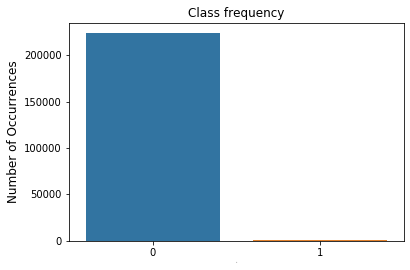

In [21]:
tmp = df["COVID-19"].value_counts()
plot_freq_chart(tmp)

### Splitting between training  and validation sets

Method below is copied from a stackoverflow answer: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

In [22]:
# 80, 20 split
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])

## Making custom dataloader

In [23]:
class CovidDataset(Dataset):
    
    def __init__(self, df, is_test, col_no, transform=None):
        self.data = df
        self.transform = transform
        self.test = is_test
        self.col_no = col_no
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = self.data.iloc[index, 0]
        source = int(self.data.iloc[index, 1].split("-")[-1])
        image = mod(source, img_name)
        label =self.data.iloc[index][3:][self.col_no]
        
        if self.transform is not None:
            # converting image to black and white
#             image = image.convert('1')
            #converting to rgb
            image = image.convert('RGB')
            # applying transforms
            image = self.transform(image)
        
        # for train loader it returns label and image both but for test loader returns only image 
        if self.test:
            return image
        else:
            return image, label

In [24]:
df

,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
0,CASE58_XRAY_1.jpeg,Source-2,1,1,1,1
1,case2_xray_1.jpeg,Source-2,1,1,1,1
2,case2_xray_2.jpeg,Source-2,1,1,1,1
3,case8_xray_1.jpeg,Source-2,1,1,1,1
4,case8_xray_2.jpeg,Source-2,1,1,1,1
...,...,...,...,...,...,...
228933,aspiration-pneumonia-5-day27.jpg,Source-5,4,1,2,0
228934,pneumocystis-jirovecii-pneumonia-3-1.jpg,Source-5,4,1,2,0
228935,pneumocystis-jirovecii-pneumonia-3-2.jpg,Source-5,4,1,2,0
228936,pneumocystis-jirovecii-pneumonia-3-3.jpg,Source-5,4,1,2,0


In [25]:
# train = train[:10]
# validate = validate[:10]

In [26]:
# apply_transform = transforms.Compose([
#     transforms.Resize((32, 32)), 
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
# BatchSize = 512

# train_ = CovidDataset(train, False, 0, transform=apply_transform)
# trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
#                                           shuffle=True, num_workers=0) # Creating dataloader

# validate_ = CovidDataset(validate, False, 0, transform=apply_transform)
# validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
#                                           shuffle=False, num_workers=0)

In [27]:
# dataloaders = {
#     'train': trainLoader,
#     'val': validateLoader
# }

# dataset_sizes = {
#     'train': len(train),
#     'val': len(validate)
# }

In [95]:
def train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = True
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print(dataset_sizes)
    best_validation_loss = 1e9 # initializing with very high error

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                # save latest for hot restart
                states = {
                    'epoch': num_epochs,
                    'state_dict': model_ft.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                torch.save(states, "./Latest_{col}")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                states = {
                    'epoch': num_epochs,
                    'state_dict': model_ft.state_dict(),
                    'optimizer': optimizer_ft.state_dict(),
                    'lr_scheduler': exp_lr_scheduler.state_dict()
                }
                torch.save(states, f"./{col}_{BatchSize}_SGD_{lr}_{epoch}")
                
            # stopping criteria
            curr_validation_loss = 0.0
            for i, data in enumerate(dataloaders['val']):
                inputs, labels = data
                if use_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model_ft(inputs)
                preds_ = torch.argmax(outputs, dim=1)
                loss_ = criterion(outputs, labels)
                curr_validation_loss += loss_

            if curr_validation_loss < best_validation_loss:
                #best model
                states = {
                    'epoch': num_epochs,
                    'state_dict': model_ft.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(states, "./Best_LeNet_0_08.mdl")
                best_validation_loss = curr_validation_loss
            else:
                #early stopping

                break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [46]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

In [47]:
df["Non-Pneumonia"].value_counts()

2    198609
0     18770
1      6327
Name: Non-Pneumonia, dtype: int64

## Upsampled Non-Pneumonia

In [48]:
def get_balanced(df, col):
    frequency_dict = train[col].value_counts()
    max_freq = frequency_dict[frequency_dict.index[0]] # 1 as counter indexes in decreasing order
    store_all = []
    for i in range(frequency_dict.shape[0]):
        temp_df = train[train[col] == i]
        temp_df_upsampled = resample(temp_df, replace=True, n_samples=max_freq, random_state=42)
        store_all.append(temp_df_upsampled)

    upsampled_df = pd.concat(store_all)
    return upsampled_df

In [49]:
col = "Non-Pneumonia"
upsampled_train = get_balanced(train, col)

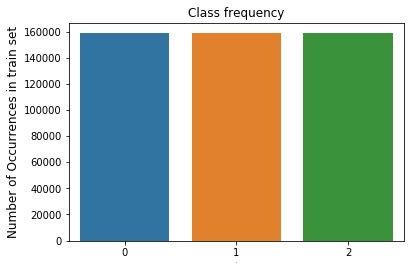

In [50]:
# just checking if dataframe is oversampled correctly and is now balanced or not
upsampled_value_counts = upsampled_train[col].value_counts()
sns.barplot(upsampled_value_counts.index, upsampled_value_counts.values)
plt.title('Class frequency')
plt.ylabel('Number of Occurrences in train set', fontsize=12)
plt.xlabel('city', fontsize=1)
plt.show()

In [51]:
apply_transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
BatchSize = 512

train_ = CovidDataset(upsampled_train, False, 0, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
                                          shuffle=True, num_workers=0) # Creating dataloader

validate_ = CovidDataset(validate, False, 0, transform=apply_transform)
validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
                                          shuffle=False, num_workers=0)

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [53]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=3)

In [54]:
lr = 0.001
num_epochs=25
        

In [55]:
train

,Image Name,Data Source,Partition,Non-Pneumonia,Other Pneumonia,COVID-19
3795,Train_reshape/CheXpert-v1.0__train__patient252...,Source-3,1,2,1,0
95674,Train_reshape/CheXpert-v1.0__train__patient354...,Source-3,3,2,1,0
35673,Train_reshape/CheXpert-v1.0__train__patient029...,Source-3,1,2,1,0
55566,Train_reshape/CheXpert-v1.0__train__patient044...,Source-3,2,0,0,0
138097,Train_reshape/CheXpert-v1.0__train__patient206...,Source-3,4,2,1,0
...,...,...,...,...,...,...
33860,Train_reshape/CheXpert-v1.0__train__patient102...,Source-3,1,2,1,0
28735,Train_reshape/CheXpert-v1.0__train__patient336...,Source-3,1,2,1,0
63220,Train_reshape/CheXpert-v1.0__train__patient290...,Source-3,2,2,1,0
26389,Train_reshape/CheXpert-v1.0__train__patient495...,Source-3,1,2,1,0


In [77]:
def final(train, validate, num_of_images):
    lr = 0.001
    num_epochs=25
    use_gpu = True
    
    validate = validate[:num_of_images]
    
    cols = ["Non-Pneumonia", "Other Pneumonia", "COVID-19"]
    for col in cols:
        upsampled_train = get_balanced(train, col)
        upsampled_train = upsampled_train[:num_of_images]
        
        apply_transform = transforms.Compose([
            transforms.Resize((32, 32)), 
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        BatchSize = 256
        print("Training df size ", upsampled_train.shape[0])
        train_ = CovidDataset(upsampled_train, False, 0, transform=apply_transform)
        trainLoader = torch.utils.data.DataLoader(train_, batch_size=BatchSize,
                                                  shuffle=True, num_workers=0) # Creating dataloader

        validate_ = CovidDataset(validate, False, 0, transform=apply_transform)
        validateLoader = torch.utils.data.DataLoader(validate_, batch_size=BatchSize,
                                          shuffle=False, num_workers=0)
        
        dataloaders = {
            'train': trainLoader,
            'val': validateLoader
        }

        dataset_sizes = {
            'train': len(train),
            'val': len(validate)
        }
        

        model_ft = models.resnet18(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 3)
        if use_gpu:
            model_ft = model_ft.cuda()

        criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)

        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
        
        model_ft = train_model(dataloaders, dataset_sizes, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)


In [80]:
final(train, validate, 3000)

Training df size  3000
{'train': 178964, 'val': 3000}
Epoch 0/24
----------
train Loss: 0.0112 Acc: 0.0118
val Loss: 1.6322 Acc: 0.0913

Epoch 1/24
----------
train Loss: 0.0004 Acc: 0.0168
val Loss: 2.6339 Acc: 0.0913

Epoch 2/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 4.1582 Acc: 0.0913

Epoch 3/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 5.8819 Acc: 0.0913

Epoch 4/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 7.3263 Acc: 0.0913

Epoch 5/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 8.4390 Acc: 0.0913

Epoch 6/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 9.3156 Acc: 0.0913

Epoch 7/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 9.8279 Acc: 0.0913

Epoch 8/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 10.2029 Acc: 0.0913

Epoch 9/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 10.4208 Acc: 0.0913

Epoch 10/24
----------
train Loss: 0.0000 Acc: 0.0168
val Loss: 10.5534 Acc: 0.0913

Epoch 11/24
----------
train 

In [55]:
tmp = pd.read_csv("data/dataset/Covid19action-radiology-CXR_v1.1/Test_Combined.csv")

In [57]:
tmp["Data Source"].value_counts()

Source-4    624
Source-3    234
Source-6     31
Source-5     25
Source-1     25
Source-2     10
Name: Data Source, dtype: int64

## Testing accuracy


In [81]:
test = pd.read_csv("data/dataset/Covid19action-radiology-CXR_v1.1/Test_Combined.csv")
test = test[test["Data Source"] != "Source-4"]

In [82]:
test_ = CovidDataset(test, False, 0, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(test_, batch_size=BatchSize,
                                          shuffle=True, num_workers=0) # Creating dataloader


In [83]:
test.shape

(325, 5)

In [85]:
cols = ["Non-Pneumonia", "Other Pneumonia", "COVID-19"]
name = {
    cols[0]: 5,
    cols[1]: 3,
    cols[2]: 3
}
for col in cols:
    correct_pred = 0
    for data in testLoader:
        inputs,labels = data
        inputs, labels = inputs.cuda(),labels.cuda()
        #load model
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model_ft = models.resnet18(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        # Here the size of each output sample is set to 2.
        # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
        model_ft.fc = nn.Linear(num_ftrs, 3)

        model_ft = model_ft.to(device)
        checkpoint = torch.load(f"./{col}_{BatchSize}_SGD_{lr}_{name[col]}")
        model_ft.load_state_dict(checkpoint['state_dict'], strict=False)
        
        # Feedforward train data batch through model
        output = model_ft(inputs) 
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        correct_pred += torch.sum(preds==labels)


    test_accuracy = correct_pred.item()/len(test)
    print('Testing accuracy = ',test_accuracy*100)

Testing accuracy =  10.76923076923077
Testing accuracy =  0.3076923076923077
Testing accuracy =  0.0


getting very bad accuracy because can't train on all data 

Can't train on whole dataset due to time and system contraints, will update the github repo in future

## Taking more images

In [99]:
final(train, validate, 223706)

Training df size  223706
{'train': 178964, 'val': 44742}
Epoch 0/24
----------


KeyboardInterrupt: 